In [11]:
# 导入必要的库
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib


In [4]:
import os
import requests

# 设置代理
os.environ['http_proxy'] = 'http://127.0.0.1:7897'
os.environ['https_proxy'] = 'http://127.0.0.1:7897'

# 测试连接（访问Google）
try:
    response = requests.get('https://www.google.com', timeout=5)
    print(f'连接状态码: {response.status_code}')
    if response.status_code == 200:
        print('代理配置成功，网络连接正常！')
except Exception as e:
    print(f'连接失败: {str(e)}')

# 打印当前代理设置
print('\n当前代理设置:')
print(f'HTTP代理: {os.environ.get("http_proxy")}')
print(f'HTTPS代理: {os.environ.get("https_proxy")}')

连接状态码: 200
代理配置成功，网络连接正常！

当前代理设置:
HTTP代理: http://127.0.0.1:7897
HTTPS代理: http://127.0.0.1:7897


In [6]:
# 加载乳腺癌数据集
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

In [7]:
# 查看数据集基本信息
print("数据集形状:", X.shape)
print("特征名称:", cancer.feature_names)
print("目标类别:", np.unique(y))
print("\n数据集描述:", cancer.DESCR[:500])  # 只显示前500个字符的描述

数据集形状: (569, 30)
特征名称: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
目标类别: [0 1]

数据集描述: .. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of 

基本统计信息：
       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
2

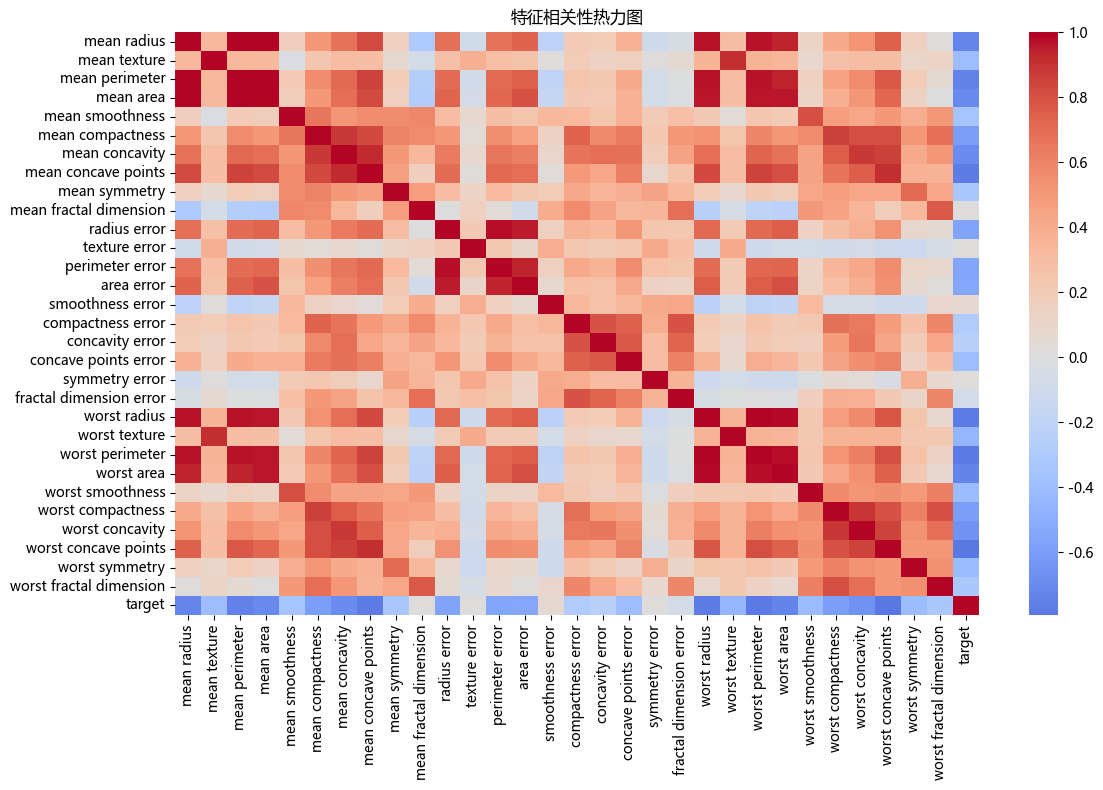

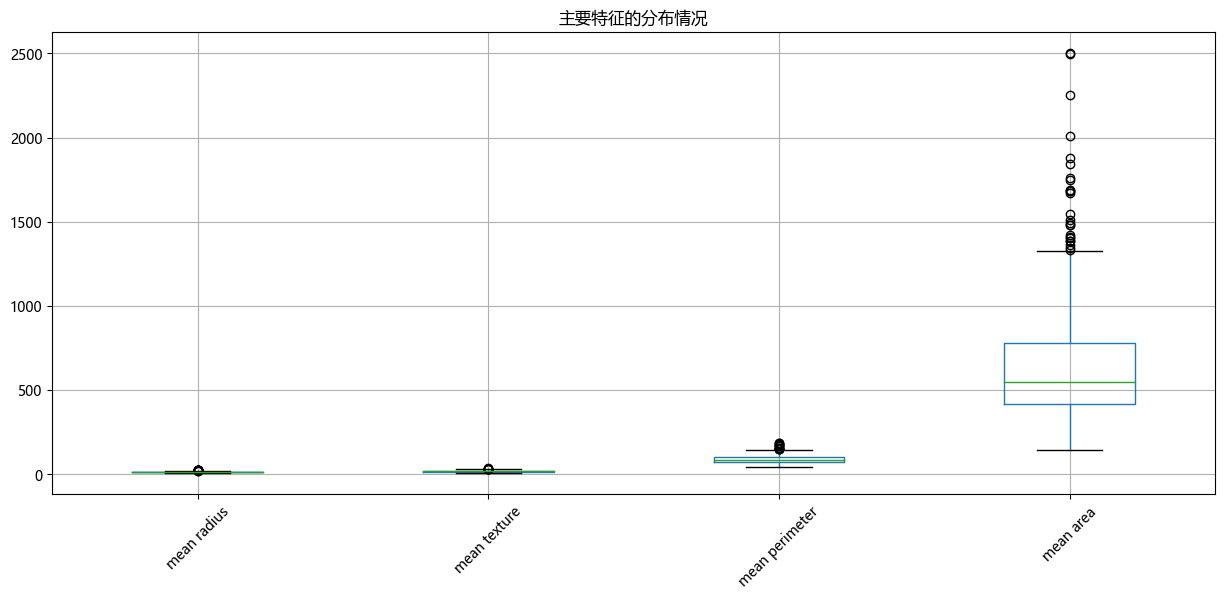


按诊断结果分组的主要特征统计：
        mean radius  mean texture  mean perimeter   mean area
target                                                       
0         17.462830     21.604906      115.365377  978.376415
1         12.146524     17.914762       78.075406  462.790196


In [12]:
# 将数据转换为DataFrame格式，方便分析
df = pd.DataFrame(X, columns=cancer.feature_names)
df['target'] = y

# 查看基本统计信息
print("基本统计信息：")
print(df.describe())

# 查看目标变量分布
print("\n目标变量分布：")
print(df['target'].value_counts(normalize=True))

matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 指定默认字体为微软雅黑
matplotlib.rcParams['axes.unicode_minus'] = False 

# 绘制相关性热力图
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('特征相关性热力图')
plt.tight_layout()
plt.show()

# 绘制箱线图来查看特征分布
plt.figure(figsize=(15, 6))
df.boxplot(column=['mean radius', 'mean texture', 'mean perimeter', 'mean area'])
plt.title('主要特征的分布情况')
plt.xticks(rotation=45)
plt.show()

# 按目标变量分组查看主要特征的统计
print("\n按诊断结果分组的主要特征统计：")
print(df.groupby('target')[['mean radius', 'mean texture', 'mean perimeter', 'mean area']].mean())

In [8]:
# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 转换为DMatrix格式（XGBoost的专用格式）
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [9]:
# 设置参数
params = {
    'objective': 'binary:logistic',  # 二分类问题
    'max_depth': 3,                  # 树的最大深度
    'eta': 0.1,                      # 学习率
    'eval_metric': 'logloss'         # 评估指标
}

# 训练模型
num_rounds = 100  # 迭代次数
watchlist = [(dtrain, 'train'), (dtest, 'eval')]
model = xgb.train(params, dtrain, num_rounds, watchlist, early_stopping_rounds=20)

# 进行预测
preds = model.predict(dtest)
predictions = [1 if pred > 0.5 else 0 for pred in preds]

# 评估模型
print("\n分类报告:")
print(classification_report(y_test, predictions))
print(f"准确率: {accuracy_score(y_test, predictions):.4f}")

[0]	train-logloss:0.60961	eval-logloss:0.61443
[1]	train-logloss:0.54076	eval-logloss:0.54721
[2]	train-logloss:0.48407	eval-logloss:0.49559
[3]	train-logloss:0.43324	eval-logloss:0.44659
[4]	train-logloss:0.38985	eval-logloss:0.40682
[5]	train-logloss:0.35213	eval-logloss:0.37082
[6]	train-logloss:0.31949	eval-logloss:0.34032
[7]	train-logloss:0.29139	eval-logloss:0.31559
[8]	train-logloss:0.26606	eval-logloss:0.29181
[9]	train-logloss:0.24392	eval-logloss:0.27323
[10]	train-logloss:0.22408	eval-logloss:0.25490
[11]	train-logloss:0.20697	eval-logloss:0.24217
[12]	train-logloss:0.19128	eval-logloss:0.22577
[13]	train-logloss:0.17705	eval-logloss:0.21283
[14]	train-logloss:0.16451	eval-logloss:0.19947
[15]	train-logloss:0.15319	eval-logloss:0.19169
[16]	train-logloss:0.14312	eval-logloss:0.18069
[17]	train-logloss:0.13410	eval-logloss:0.17432
[18]	train-logloss:0.12522	eval-logloss:0.16573
[19]	train-logloss:0.11687	eval-logloss:0.15517
[20]	train-logloss:0.10980	eval-logloss:0.15131
[2

[0]	train-logloss:0.60961	eval-logloss:0.61443
[1]	train-logloss:0.54076	eval-logloss:0.54721
[2]	train-logloss:0.48407	eval-logloss:0.49559
[3]	train-logloss:0.43324	eval-logloss:0.44659
[4]	train-logloss:0.38985	eval-logloss:0.40682
[5]	train-logloss:0.35213	eval-logloss:0.37082
[6]	train-logloss:0.31949	eval-logloss:0.34032
[7]	train-logloss:0.29139	eval-logloss:0.31559
[8]	train-logloss:0.26606	eval-logloss:0.29181
[9]	train-logloss:0.24392	eval-logloss:0.27323
[10]	train-logloss:0.22408	eval-logloss:0.25490
[11]	train-logloss:0.20697	eval-logloss:0.24217
[12]	train-logloss:0.19128	eval-logloss:0.22577
[13]	train-logloss:0.17705	eval-logloss:0.21283
[14]	train-logloss:0.16451	eval-logloss:0.19947
[15]	train-logloss:0.15319	eval-logloss:0.19169
[16]	train-logloss:0.14312	eval-logloss:0.18069
[17]	train-logloss:0.13410	eval-logloss:0.17432
[18]	train-logloss:0.12522	eval-logloss:0.16573
[19]	train-logloss:0.11687	eval-logloss:0.15517
[20]	train-logloss:0.10980	eval-logloss:0.15131
[2

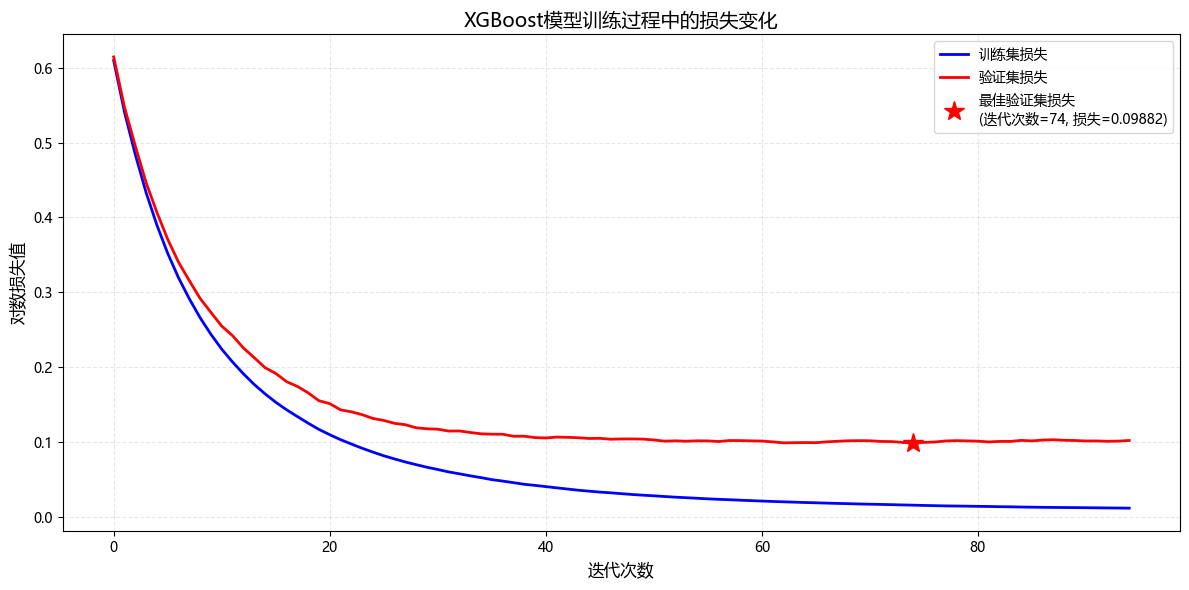

最佳迭代次数: 74
最佳验证集损失: 0.09882
对应的训练集损失: 0.01570


In [14]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 加载数据
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

# 分割数据
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 转换为DMatrix格式
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 设置参数
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'eta': 0.1,
    'eval_metric': 'logloss'
}

# 创建列表来存储训练过程中的损失值
results = {}

# 训练模型
num_rounds = 95
watchlist = [(dtrain, 'train'), (dtest, 'eval')]
model = xgb.train(params, dtrain, num_rounds, watchlist, evals_result=results)

# 提取损失值
train_losses = results['train']['logloss']
eval_losses = results['eval']['logloss']
iterations = range(len(train_losses))

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# 创建图形
plt.figure(figsize=(12, 6))

# 绘制训练集和验证集的学习曲线
plt.plot(iterations, train_losses, label='训练集损失', color='blue', linewidth=2)
plt.plot(iterations, eval_losses, label='验证集损失', color='red', linewidth=2)

# 标注最佳验证集损失点
best_eval_iteration = np.argmin(eval_losses)
best_eval_loss = min(eval_losses)
plt.plot(best_eval_iteration, best_eval_loss, 'r*', markersize=15, 
         label=f'最佳验证集损失\n(迭代次数={best_eval_iteration}, 损失={best_eval_loss:.5f})')

# 添加标题和标签
plt.title('XGBoost模型训练过程中的损失变化', fontsize=14)
plt.xlabel('迭代次数', fontsize=12)
plt.ylabel('对数损失值', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

# 添加网格
plt.grid(True, linestyle='--', alpha=0.3)

# 显示图形
plt.tight_layout()
plt.show()

# 打印最佳迭代次数和对应的损失值
print(f"最佳迭代次数: {best_eval_iteration}")
print(f"最佳验证集损失: {best_eval_loss:.5f}")
print(f"对应的训练集损失: {train_losses[best_eval_iteration]:.5f}")

<Figure size 1000x600 with 0 Axes>

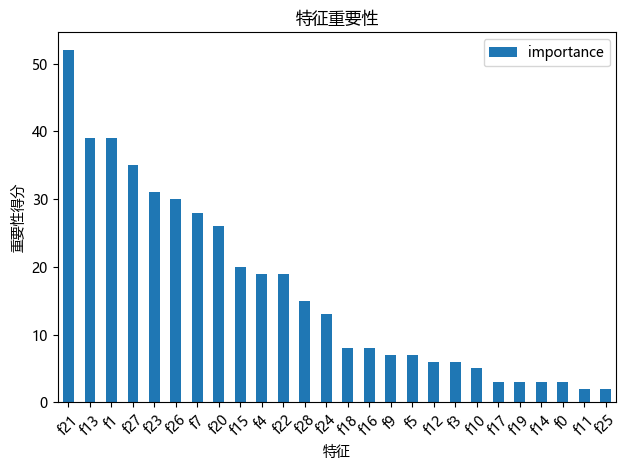

In [13]:
# 获取特征重要性
importance = model.get_score(importance_type='weight')
importance = pd.DataFrame.from_dict(importance, orient='index', columns=['importance'])
importance = importance.sort_values('importance', ascending=False)

# 绘制特征重要性图
plt.figure(figsize=(10, 6))
importance.plot(kind='bar')
plt.title('特征重要性')
plt.xlabel('特征')
plt.ylabel('重要性得分')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [1]:
import numpy as np
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
from tqdm import tqdm  # 添加进度条

e:\Anaconda\envs\xgboost_env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
class ABCOptimizer:
    def __init__(self, n_bees=20, max_trials=100, max_cycles=50):
        self.n_bees = n_bees
        self.max_trials = max_trials
        self.max_cycles = max_cycles
        self.history = []  # 记录优化历史
        
        # 定义参数搜索范围
        self.param_bounds = {
            'max_depth': (3, 10),
            'eta': (0.01, 0.3),
            'subsample': (0.6, 1.0),
            'colsample_bytree': (0.6, 1.0),
            'min_child_weight': (1, 7),
            'gamma': (0, 0.5),
            'lambda': (0.1, 5.0),  # L2正则化
            'alpha': (0, 1.0)      # L1正则化
        }
    
    def initialize_food_sources(self):
        """初始化食物源（参数组合）"""
        food_sources = []
        for _ in range(self.n_bees):
            params = {
                'max_depth': np.random.randint(
                    self.param_bounds['max_depth'][0],
                    self.param_bounds['max_depth'][1] + 1
                ),
                'eta': np.random.uniform(
                    self.param_bounds['eta'][0],
                    self.param_bounds['eta'][1]
                ),
                'subsample': np.random.uniform(
                    self.param_bounds['subsample'][0],
                    self.param_bounds['subsample'][1]
                ),
                'colsample_bytree': np.random.uniform(
                    self.param_bounds['colsample_bytree'][0],
                    self.param_bounds['colsample_bytree'][1]
                ),
                'min_child_weight': np.random.randint(
                    self.param_bounds['min_child_weight'][0],
                    self.param_bounds['min_child_weight'][1] + 1
                ),
                'gamma': np.random.uniform(
                    self.param_bounds['gamma'][0],
                    self.param_bounds['gamma'][1]
                ),
                'lambda': np.random.uniform(
                    self.param_bounds['lambda'][0],
                    self.param_bounds['lambda'][1]
                ),
                'alpha': np.random.uniform(
                    self.param_bounds['alpha'][0],
                    self.param_bounds['alpha'][1]
                )
            }
            food_sources.append(params)
        return food_sources
        
    def evaluate_params(self, params, X, y):
        """评估参数组合的性能"""
        try:
            model = xgb.XGBClassifier(
                objective='binary:logistic',
                eval_metric='logloss',  # 显式指定评估指标
                use_label_encoder=False,  # 禁用标签编码器
                **params,
                random_state=42
            )
            scores = cross_val_score(model, X, y, cv=5, scoring='neg_log_loss')
            return -np.mean(scores)
        except Exception as e:
            print(f"评估出错: {e}")
            return float('inf')
    def employed_bee_phase(self, food_sources, X, y):
        """雇佣蜂阶段"""
        new_sources = []
        for source in food_sources:
            # 在当前解附近搜索
            new_source = source.copy()
            param = np.random.choice(list(source.keys()))
            
            if param == 'max_depth' or param == 'min_child_weight':
                bounds = self.param_bounds[param]
                new_source[param] = np.random.randint(bounds[0], bounds[1] + 1)
            else:
                bounds = self.param_bounds[param]
                new_source[param] = np.random.uniform(bounds[0], bounds[1])
            
            # 评估新解
            old_score = self.evaluate_params(source, X, y)
            new_score = self.evaluate_params(new_source, X, y)
            
            if new_score < old_score:
                new_sources.append(new_source)
            else:
                new_sources.append(source)
        
        return new_sources
    
    def optimize(self, X, y):
        """主优化循环"""
        food_sources = self.initialize_food_sources()
        best_source = None
        best_score = float('inf')
        
        # 使用tqdm显示优化进度
        for cycle in tqdm(range(self.max_cycles), desc="优化进度"):
            # 雇佣蜂阶段
            food_sources = self.employed_bee_phase(food_sources, X, y)
            
            # 观察蜂阶段
            scores = [self.evaluate_params(source, X, y) for source in food_sources]
            probabilities = 1 / (1 + np.array(scores))
            probabilities = probabilities / np.sum(probabilities)
            
            # 更新最佳解
            min_score_idx = np.argmin(scores)
            if scores[min_score_idx] < best_score:
                best_score = scores[min_score_idx]
                best_source = food_sources[min_score_idx].copy()
            
            # 记录历史
            self.history.append(best_score)
            
            # 侦查蜂阶段
            for i in range(len(food_sources)):
                if np.random.random() < 0.1:  # 10%概率重新初始化
                    food_sources[i] = self.initialize_food_sources()[0]
            
            print(f"\nCycle {cycle+1}, Best Score: {best_score:.6f}")
        
        return best_source, best_score
    
    def plot_optimization_history(self):
        """绘制优化历史曲线"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.history, 'b-', label='最佳损失值')
        plt.title('ABC优化过程')
        plt.xlabel('迭代次数')
        plt.ylabel('损失值')
        plt.grid(True)
        plt.legend()
        plt.show()

优化进度:   3%|▎         | 1/30 [00:13<06:17, 13.02s/it]


Cycle 1, Best Score: 0.092152


优化进度:   7%|▋         | 2/30 [00:25<05:58, 12.82s/it]


Cycle 2, Best Score: 0.092152


优化进度:  10%|█         | 3/30 [00:38<05:42, 12.69s/it]


Cycle 3, Best Score: 0.091710


优化进度:  13%|█▎        | 4/30 [00:51<05:30, 12.72s/it]


Cycle 4, Best Score: 0.091397


优化进度:  17%|█▋        | 5/30 [01:03<05:17, 12.70s/it]


Cycle 5, Best Score: 0.091397


优化进度:  20%|██        | 6/30 [01:17<05:16, 13.20s/it]


Cycle 6, Best Score: 0.091397


优化进度:  23%|██▎       | 7/30 [01:31<05:08, 13.43s/it]


Cycle 7, Best Score: 0.091397


优化进度:  27%|██▋       | 8/30 [01:45<04:58, 13.57s/it]


Cycle 8, Best Score: 0.091397


优化进度:  30%|███       | 9/30 [01:59<04:44, 13.52s/it]


Cycle 9, Best Score: 0.089935


优化进度:  33%|███▎      | 10/30 [02:12<04:28, 13.42s/it]


Cycle 10, Best Score: 0.089935


优化进度:  37%|███▋      | 11/30 [02:24<04:10, 13.21s/it]


Cycle 11, Best Score: 0.089935


优化进度:  40%|████      | 12/30 [02:38<03:59, 13.29s/it]


Cycle 12, Best Score: 0.089935


优化进度:  43%|████▎     | 13/30 [02:51<03:45, 13.26s/it]


Cycle 13, Best Score: 0.089935


优化进度:  47%|████▋     | 14/30 [03:04<03:30, 13.15s/it]


Cycle 14, Best Score: 0.089935


优化进度:  50%|█████     | 15/30 [03:17<03:17, 13.14s/it]


Cycle 15, Best Score: 0.089935


优化进度:  53%|█████▎    | 16/30 [03:30<03:03, 13.07s/it]


Cycle 16, Best Score: 0.089935


优化进度:  57%|█████▋    | 17/30 [03:43<02:48, 12.99s/it]


Cycle 17, Best Score: 0.089935


优化进度:  60%|██████    | 18/30 [03:56<02:35, 12.96s/it]


Cycle 18, Best Score: 0.089935


优化进度:  63%|██████▎   | 19/30 [04:09<02:22, 12.97s/it]


Cycle 19, Best Score: 0.089935


优化进度:  67%|██████▋   | 20/30 [04:23<02:12, 13.24s/it]


Cycle 20, Best Score: 0.089935


优化进度:  70%|███████   | 21/30 [04:36<01:58, 13.15s/it]


Cycle 21, Best Score: 0.089935


优化进度:  73%|███████▎  | 22/30 [04:49<01:46, 13.37s/it]


Cycle 22, Best Score: 0.089935


优化进度:  77%|███████▋  | 23/30 [05:03<01:33, 13.32s/it]


Cycle 23, Best Score: 0.089935


优化进度:  80%|████████  | 24/30 [05:16<01:20, 13.36s/it]


Cycle 24, Best Score: 0.089935


优化进度:  83%|████████▎ | 25/30 [05:30<01:07, 13.53s/it]


Cycle 25, Best Score: 0.088721


优化进度:  87%|████████▋ | 26/30 [05:44<00:54, 13.52s/it]


Cycle 26, Best Score: 0.088721


优化进度:  90%|█████████ | 27/30 [05:56<00:40, 13.36s/it]


Cycle 27, Best Score: 0.088721


优化进度:  93%|█████████▎| 28/30 [06:10<00:26, 13.44s/it]


Cycle 28, Best Score: 0.086668


优化进度:  97%|█████████▋| 29/30 [06:22<00:13, 13.07s/it]


Cycle 29, Best Score: 0.086668


优化进度: 100%|██████████| 30/30 [06:35<00:00, 13.18s/it]


Cycle 30, Best Score: 0.086668

最佳参数组合:
max_depth: 10
eta: 0.24012156195022574
subsample: 0.7623055982084108
colsample_bytree: 0.7708893827087544
min_child_weight: 2
gamma: 0.14358261818578283
lambda: 1.3744806162572913
alpha: 0.21858025783692425
最佳得分: 0.08666833927688589
[0]	validation_0-logloss:0.51934	validation_1-logloss:0.52543
[1]	validation_0-logloss:0.40459	validation_1-logloss:0.41424
[2]	validation_0-logloss:0.32605	validation_1-logloss:0.34159
[3]	validation_0-logloss:0.26609	validation_1-logloss:0.28517
[4]	validation_0-logloss:0.22376	validation_1-logloss:0.24360
[5]	validation_0-logloss:0.18948	validation_1-logloss:0.20733
[6]	validation_0-logloss:0.16226	validation_1-logloss:0.18411
[7]	validation_0-logloss:0.14029	validation_1-logloss:0.16585
[8]	validation_0-logloss:0.12255	validation_1-logloss:0.15562
[9]	validation_0-logloss:0.10851	validation_1-logloss:0.14292
[10]	validation_0-logloss:0.09754	validation_1-logloss:0.13974
[11]	validation_0-logloss:0.08771	validatio


e:\Anaconda\envs\xgboost_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Anaconda\envs\xgboost_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32456 (\N{CJK UNIFIED IDEOGRAPH-7EC8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Anaconda\envs\xgboost_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Anaconda\envs\xgboost_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Anaconda\envs\xgboost_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  fig.canva

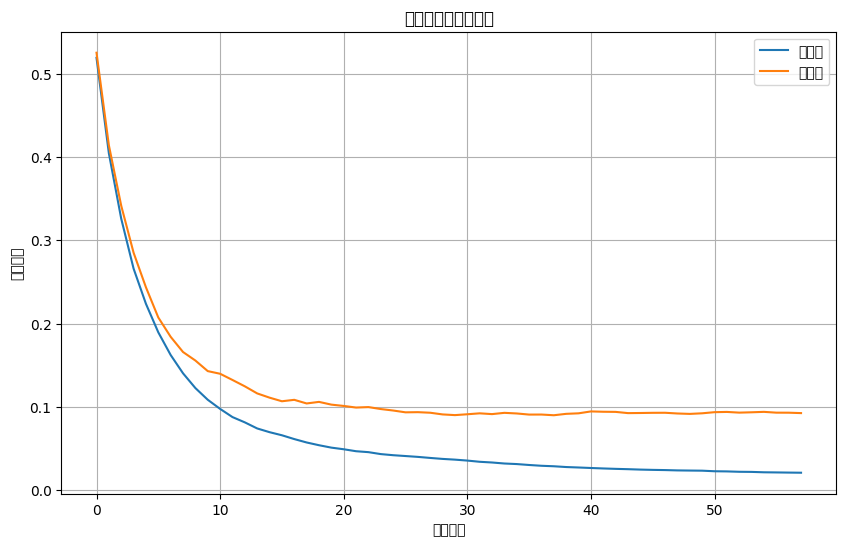

In [3]:
# 主程序修改
if __name__ == "__main__":
    # 加载数据
    cancer = load_breast_cancer()
    X, y = cancer.data, cancer.target
    
    # 确保标签是从0开始的整数
    y = (y == 1).astype(int)
    
    # 分割数据
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 初始化ABC优化器
    abc_optimizer = ABCOptimizer(n_bees=20, max_cycles=30)
    
    # 运行优化
    best_params, best_score = abc_optimizer.optimize(X_train, y_train)
    
    # 打印最佳参数
    print("\n最佳参数组合:")
    for param, value in best_params.items():
        print(f"{param}: {value}")
    print(f"最佳得分: {best_score}")
    
    # 使用最佳参数训练最终模型
    final_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',  # 显式指定评估指标
        use_label_encoder=False,  # 禁用标签编码器
        **best_params,
        random_state=42
    )
    
    # 训练并评估最终模型
    eval_set = [(X_train, y_train), (X_test, y_test)]
    final_model.fit(
        X_train, y_train,
        eval_set=eval_set,
        eval_metric='logloss',
        early_stopping_rounds=20,
        verbose=True
    )
    
    # 绘制最终模型的学习曲线
    results = final_model.evals_result()
   

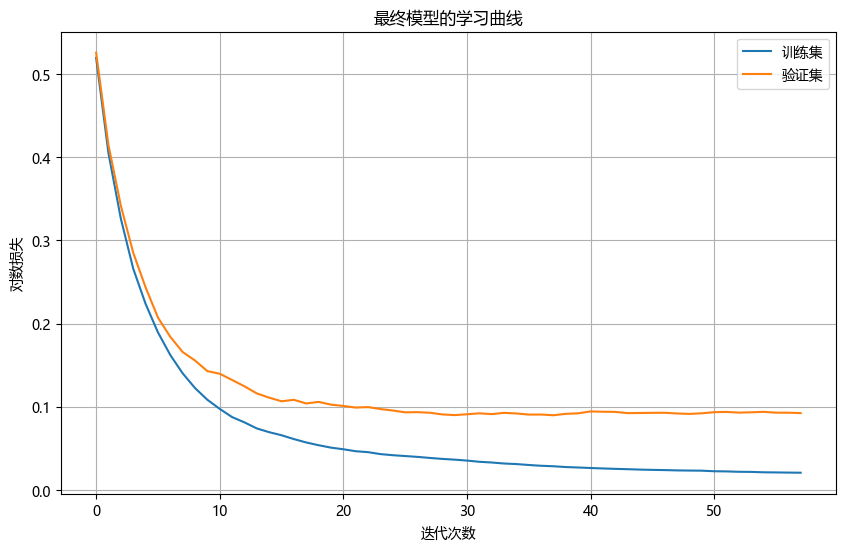

In [4]:
 # 设置中文字体
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
    
plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['logloss'], label='训练集')
plt.plot(results['validation_1']['logloss'], label='验证集')
plt.title('最终模型的学习曲线')
plt.xlabel('迭代次数')
plt.ylabel('对数损失')
plt.legend()
plt.grid(True)
plt.show()